In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rand
from sklearn.preprocessing import MinMaxScaler
from collections import deque

In [2]:
import os
os.chdir('C:\\code\\activ')

In [3]:
df_name = 'nov_nine_var.xlsx'

In [4]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.set_printoptions(precision=6, suppress=True)

In [5]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [13]:
# dqn paramater
GAMMA = 0.9
BATCH_SIZE = 1000
SEQUENCE_LENGTH = 12
EPISODE_DONE = 100
EPS_DECAY = 0.99

In [14]:
df = pd.read_excel('./documents/' + df_name).iloc[:,1::]

scaler = MinMaxScaler()
X = scaler.fit_transform(df.iloc[:,0:21].to_numpy())

starting_state = X[-1].reshape(1, 21)

In [36]:
def set_goal(goal_df_name):
    """ set goal destination
    Args:
        goal_df_name(str): df_name in documents/result/
    Returns:
        goal_state(ndArray, (1, 21)): the state of lowest rate in df
    """
    goal_df = pd.read_excel('./documents/result/' + goal_df_name).iloc[:,1::].to_numpy()
    index = goal_df[:,-1].argmin()

    goal_state = goal_df[:,0:21][index].reshape(1, 21)
    goal_state = scaler.transform(goal_state)

    return goal_state

In [23]:
def return_action(i):
    a = np.zeros((1, 21))
    j = i // 2

    if i % 2 == 0:
        a[0][j] = -0.01
    
    else:
        a[0][j] = 0.01
    
    return a

In [26]:
def return_state(s, a):
    ns = s + a
    return ns

In [28]:
def return_reward(ns, gs):
    dist = np.sqrt(np.sum(np.square(gs - ns)))
    loss = dist
    
    return -loss

In [30]:
class DQN_Network(tf.keras.models.Model):
    def __init__(self):
        super(DQN_Network, self).__init__()
        self.input_layer = tf.keras.layers.Dense(128, input_shape=(21, ), activation='relu')

        self.hidden_layer = tf.keras.models.Sequential()
        self.hidden_layer.add(tf.keras.layers.Dense(128, activation='relu'))
        self.hidden_layer.add(tf.keras.layers.Dense(128, activation='relu'))

        self.ouput_layer = tf.keras.layers.Dense(42, activation='linear')

    def call(self, x):
        i = self.input_layer(x)
        h = self.hidden_layer(i)
        o = self.ouput_layer(h)
        return o

In [40]:
class DQN_Agent:
    def __init__(self):
        self.train_model = self.set_model()
        self.target_model = self.set_model()

        self.memory = deque(maxlen=20000)
        self.episode = 1

        self.optim = tf.keras.optimizers.Adam(learning_rate=1e-10)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def set_model(self):
        net = DQN_Network()
        net.build(input_shape=(1, 21))

        optim = tf.keras.optimizers.Adam(learning_rate=1e-10)
        net.compile(optimizer=optim, loss='mse')
        return net

    def memorize(self, cs, a, a_i, r, ns, d):
        if d:
            self.episode += 1
        
        self.memory.append(
            (
                tf.convert_to_tensor(tf.cast(cs, tf.float32)),
                tf.convert_to_tensor(tf.cast(a, tf.float32)),
                a_i,
                tf.convert_to_tensor(tf.cast(r, tf.float32)),
                tf.convert_to_tensor(tf.cast(ns, tf.float32)),
                d
            )
        )

    def convert_memory_to_input(self):
        batch = rand.sample(self.memory, BATCH_SIZE)
        s, a, a_i, r, ns, d = zip(*batch)

        states = tf.convert_to_tensor(s).reshape(BATCH_SIZE, 21)
        actions = tf.convert_to_tensor(a).reshape(BATCH_SIZE, 21)
        action_indexs = tf.convert_to_tensor(a_i)
        rewards = tf.convert_to_tensor(r)
        next_states = tf.convert_to_tensor(ns).reshape(BATCH_SIZE, 21)
        dones = tf.convert_to_tensor(d)

        return states, actions, action_indexs, rewards, next_states, dones

    def act(self, state):
        # if self.episode >= 0 and self.episode < 200:
        #     eps_threshold = -(self.episode/1000)+1+(self.episode)*(self.episode-200)/300000
        # else:
        #     eps_threshold = -(self.episode/1000)+1+(self.episode-200)*(self.episode-1000)

        eps_threshold = EPS_DECAY ** self.episode

        a_r = self.train_model(state)

        if rand.random() > eps_threshold:
            a_i = np.argmax(a_r)
        else:
            a_i = rand.randint(0, 41)

        a = return_action(a_i)

        return a, a_i, eps_threshold

    def run(self):
        if len(self.memory) < BATCH_SIZE:
            return 1

        states, actions, action_indexs, rewards, next_states, dones = self.convert_memory_to_input()
        loss = self.learn(states, actions, action_indexs, rewards, next_states, dones)
    
        return loss.numpy()
        
    @tf.function
    def learn(self, states, actions, action_indexs, rewards, next_states, dones):
        target_q = self.target_model(next_states)

        q_target = rewards + (1 - dones) * GAMMA * tf.reduce_max(target_q, axis=1, keepdims=True)

        with tf.GradientTape() as tape:
            current_q = self.train_model(states) # 현재 상황에서 할 수 있는 행동들의 q value
            current_q = tf.reduce_sum(current_q[action_indexs], axis=1, keepdims=True) # 실제 한 행동에 대한 q value

            loss = self.loss_fn(current_q, q_target)
        grads = tape.gradient(loss, self.train_model.trainable_weights)
        self.optim.apply_gradients(zip(grads, self.train_model.trainable_weights))

        return loss

In [41]:
agent = DQN_Agent()
rewards_hist = []
st_hist = []

goal_state = set_goal('basic_formula.xlsx').reshape(1, 21)
for e in range(10000):
    counter = [0 for i in range(42)]
    state = starting_state
    steps = 0
    rewards = 0

    if e % 50 == 0:
        agent.target_model.set_weights(agent.train_model.get_weights())

    while True:
        action, idx, eps = agent.act(state)
        counter[idx] += 1
        next_state = return_state(state, action)
        reward = return_reward(next_state, goal_state)

        if steps == EPISODE_DONE or all(state[0][i] == goal_state[0][i] for i in range(21)):
            done = True
        else:
            done = False

        agent.memorize(state, action, idx, reward, next_state, done)
        loss = agent.run()

        state = next_state
        rewards += reward
        steps += 1

        if steps % 10 == 0:
            print(f'steps: {steps}, reward: {reward}')

        if done:
            print(f'============={e}=============')
            print(round(rewards, 3), round(loss, 3), max(counter), round(eps, 5))
            print("=============================")
            rewards_hist.append(rewards)
            st_hist.append(state)
            break

steps: 10, reward: -1.7278389286697218
steps: 20, reward: -1.7214607580788477
steps: 30, reward: -1.7139814509021793
steps: 40, reward: -1.7212047105346107
steps: 50, reward: -1.7234513614019609
steps: 60, reward: -1.7254773536976085
steps: 70, reward: -1.7262601565555067
steps: 80, reward: -1.7349140386789015
steps: 90, reward: -1.7435472509866186
steps: 100, reward: -1.739156735043553
=============0=============
-174.404 1 7 0.99
steps: 10, reward: -1.7151332510124833
steps: 20, reward: -1.7165525970371973
steps: 30, reward: -1.7301179625571221
steps: 40, reward: -1.7304441381764015
steps: 50, reward: -1.7379534426492504
steps: 60, reward: -1.7412828415734862
steps: 70, reward: -1.7491851080748921
steps: 80, reward: -1.754894473412986
steps: 90, reward: -1.7638896675097857
steps: 100, reward: -1.7727495396683806
=============1=============
-175.639 1 6 0.9801
steps: 10, reward: -1.724048668612135
steps: 20, reward: -1.728299147180132
steps: 30, reward: -1.7278160344095108
steps: 40, 

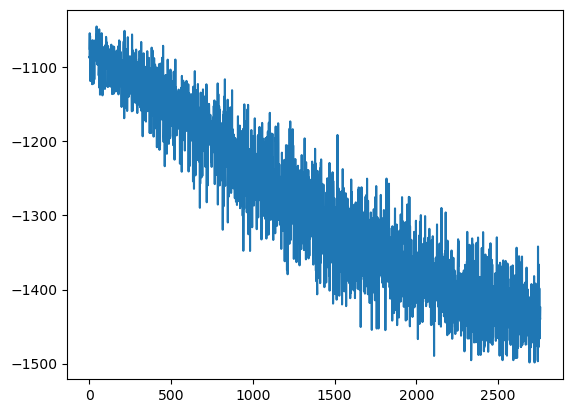

In [ ]:
plt.plot(rewards_hist)